# Ingest and process data

This notebook loads the data that was stored on Box, and converts it to dataframe and dataset with a common format across all collections.

It provides functionality for downlaoding images.

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from weavingtools.collection_tools import SMGCollection, NMSCollection
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import chromadb

In [9]:
nms = NMSCollection(img_folder='nms_imgs')
nms.load_original_csvs(files=list(Path('data').glob('NMS_Metadata*.*')))
nms.save_csv('data/NMS.csv')

In [10]:
smg = SMGCollection( img_folder='smg_imgs')
smg.load_from_json('data/smg_objects_06_06_2022.json')
smg.save_csv('data/SMG.csv')

0it [00:00, ?it/s]

#   Download images

In [5]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')


In [6]:
collection.fetch_images(n=10)

before downloading 60184
remaining images to download 88922


  0%|          | 0/10 [00:00<?, ?it/s]

after downloading 60192


In [7]:
# download images by category
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications',#'Photography','Photographic Technology',
            'Textiles – Plastics', 'Modern Materials', 'Textile Industry', 'Textiles Machinery'
            'Energy – Water Supply & Sanitation', 'Heat Engines (non steam)', 'Metallurgy', 'Hand and Machine Tools', 'Electricity Supply', 'Domestic Appliances', 
            'Tools of the Trade & Personal Accessories', 'Lighting', 'Motive Power', 'Coal Mining', 'Mining & Ore Dressing', 'Gas Industry', 'Heat', 'Nuclear Physics', 
            'Pumping Machinery', "Marine Engines", 'Industrial Metrology', 'Nuclear Energy', 'Environmental Science & Technology', 'Civil Engineering', 'Mechanical Power Transmission'
 ]
comms = smg_img_overview[smg_img_overview.category.isin(categories)]
print(comms.shape)

record_ids = set(comms.record_url.apply(lambda x: x.split('/')[-1]))
collection.fetch_images(record_ids=record_ids)

(19657, 6)
before downloading 60192
['303/414/medium_SMG00022645.jpg', '302/805/medium_SMG00022220.jpg', '306/489/medium_SMG00067710.jpg', '306/487/medium_SMG00067708.jpg', '459/693/medium_SMG00271243.jpg', '310/845/medium_1999_7326__0001_.jpg', '310/285/medium_SMG00030370_0.jpg', '323/542/medium_SMG00044117_0.jpg', '305/287/medium_SMG00022698_0.jpg', '436/226/medium_SMG00078605.jpg', '436/240/medium_SMG00078632.jpg', '461/119/medium_SMG00267680.jpg', '436/233/medium_SMG00078618.jpg', '406/970/medium_SMG00094359.jpg', '435/407/medium_SMG00055615.jpg', '306/411/medium_SMG00067292.jpg', '332/496/medium_SMG00179850.jpg', '306/420/medium_SMG00067301.jpg', '306/413/medium_SMG00067294.jpg', '480/347/medium_SMG00251582.jpg', '476/982/medium_SMG00246127.jpg', '320/192/medium_Y1996_0010_1115_0002__0001_.jpg', '461/434/medium_SMG00303059.jpg', '461/101/medium_SMG00267658.jpg', '435/445/medium_SMG00067288.jpg', '300/899/medium_SMG00064515.jpg', '300/917/medium_SMG00064536.jpg', '300/898/medium_SM

  0%|          | 0/129 [00:00<?, ?it/s]

after downloading 60192


In [8]:
collection = NMSCollection(img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
collection.fetch_images(n=5)

  0%|          | 0/1444 [00:00<?, ?it/s]

In [ ]:
img_ids = [p for p in collection.df.img_loc.to_list() if isinstance(p,str)]
collection.fetch_images(imgs_ids=img_ids)

# Filter communications data

In [11]:
# open the spreadsheet with image lookup
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
# select the categories we want to include in the communications collections
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications',#'Photography','Photographic Technology',
            'Textiles – Plastics', 'Modern Materials', 'Textile Industry', 'Textiles Machinery'
            'Energy – Water Supply & Sanitation', 'Heat Engines (non steam)', 'Metallurgy', 'Hand and Machine Tools', 'Electricity Supply', 'Domestic Appliances', 
            'Tools of the Trade & Personal Accessories', 'Lighting', 'Motive Power', 'Coal Mining', 'Mining & Ore Dressing', 'Gas Industry', 'Heat', 'Nuclear Physics', 
            'Pumping Machinery', "Marine Engines", 'Industrial Metrology', 'Nuclear Energy', 'Environmental Science & Technology', 'Civil Engineering', 'Mechanical Power Transmission'
 ]#df_comms = smg_img_overview[smg_img_overview.apply(lambda x: 'commun' in x.category.lower(), axis=1)] 
# select objects from based on these categories
df_comms = smg_img_overview[smg_img_overview.category.isin(categories)]
# get object ids for communication object
object_ids = df_comms.record_url.apply(lambda x: x.split('/')[-1])
smg.df.img_path = smg.df.img_path.apply(lambda x: Path(x)) 
smg.df = smg.df[smg.df.record_id.isin(object_ids)]
smg.df = smg.df[smg.df.img_path.apply(lambda x: x.is_file() and not x.is_dir())].reset_index(drop=True)
smg.df.shape,df_comms.shape

((18841, 10), (19657, 6))

In [12]:
nms.df = nms.df[nms.df.img_name.str.endswith('.jpg').fillna(False).astype(bool) &  
                nms.df.img_name.str.startswith(('PF','MP')).fillna(False).astype(bool)
                ].reset_index(drop=True)
nms.df.downloaded = True
nms.df.shape

(1478, 10)

# Create Vector Database

In [99]:
# add collection name to the dataframes to later we can filter by collection
smg.df['collection'] = smg.collection_name; nms.df['collection'] = nms.collection_name
# concatenate the dataframes
collection_df = pd.concat([smg.df,nms.df],axis=0); 
# remove rows for which we don't hvae an image stored locally
collection_df = collection_df[~collection_df.img_path.apply(lambda x: Path(x).is_dir())]
# reset index so we can use it later in the database as ids
collection_df.reset_index(drop=True,inplace=True)
# convert image path to string to aoivd issues with the database
collection_df['img_path'] = collection_df.img_path.apply(lambda x: str(x))
print('Collections has',collection_df.shape[0],'rows')
# save the data to a csv file
collection_df.to_csv('data/heritage_weaver_data.csv')

Collections has 20319 rows


In [161]:
import chromadb
import json
from weavingtools.embedding_tools import SigLIPEmbedder, ImageLoaderRGB, index_data
from weavingtools.linkage_tools import plot_query_results

ModuleNotFoundError: No module named 'weavingtools.linkage_tools'

In [101]:
# select model to use for embedding both text and images
checkpoint = 'google/siglip-base-patch16-224'
# initialise the embedder which we will attach to the database
siglip_embedder = SigLIPEmbedder(checkpoint)
# initate the image loader
data_loader = ImageLoaderRGB()
# initiate the client
client = chromadb.PersistentClient(path="hw_db")

In [118]:
try:
    client.delete_collection(name="heritage_weaver")
except Exception as e:
    print(e)

In [119]:
# initiate the collection in the database
collection_db = client.get_or_create_collection(name="heritage_weaver", 
                                             metadata={"hnsw:space": "cosine"}, # we will use cosine distance for similarity search
                                            embedding_function=siglip_embedder, # the embedder for the collection (text and images)
                                            data_loader=data_loader # procedure for loading the image data
                                            )

In [120]:
# collection = nms # smg | nms
# collection.df.downloaded = True



In [121]:
# image_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_url','img_path',]].values.tolist())
# text_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_url','img_path',]].values.tolist())


In [122]:
collection_db.count()

0

In [124]:
index_data(collection_db, collection_df, batch_size=32)

  0%|          | 0/634 [00:00<?, ?it/s]

/Users/kasparbeelen/Documents/CongruenceEngine/heritage-weaver/weavingtools/embedding_tools.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['modality'] = 'image'
/Users/kasparbeelen/Documents/CongruenceEngine/heritage-weaver/weavingtools/embedding_tools.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['modality'] = 'text'
/Users/kasparbeelen/Documents/CongruenceEngine/heritage-weaver/weavingtools/embedding_tools.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [31]:
# for b in tqdm(text_batches):
#     content, metadatas = reshape_text_batch(b, collection.collection_name)
#     counter = collection_db.count()
#     ids = [str(i) for i in range(counter,counter+len(content))]
#     collection_db.add(
#         ids = ids,
#         documents = content,
#         metadatas = metadatas
#     )

0it [00:00, ?it/s]

In [125]:
collection_db.count()

91447

Davy Safety Lamp for Gas Testing, 1887-1897.

Safety lamp, Davy, blue glass, use: gas testing, maker: J. Abbot and Co. Ltd., Gateshead, marking: makers name, 1887-97; Davy safety lamp for gas testing. This lamp is modified with a piece of blue glass for use in gas testing. In the presence of explosive gas the flame burns with a bluish colour and can be more readily seen when viewed through blue glass.


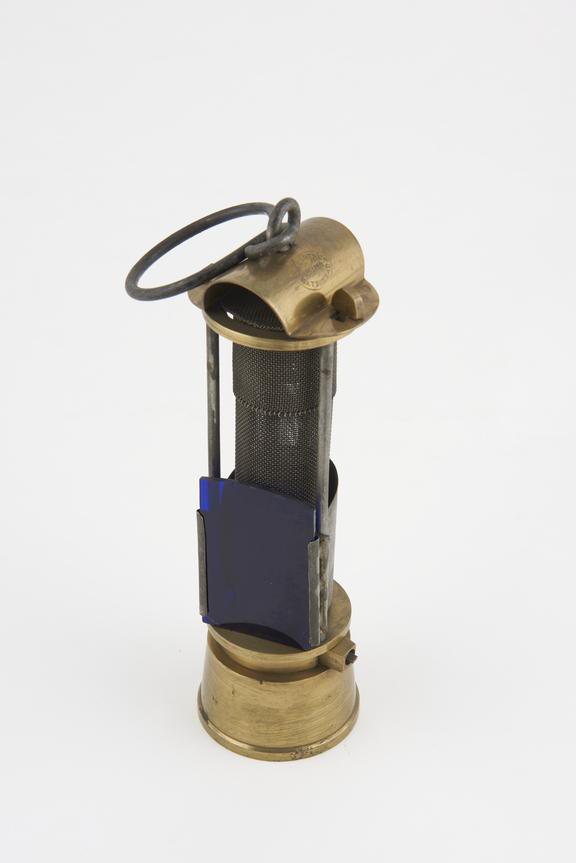

In [154]:

idx = 10323
query_img = smg.df[smg.df.downloaded==True].img_path.iloc[idx]
print(smg.df[smg.df.downloaded==True].description.iloc[idx])
Image.open(query_img)

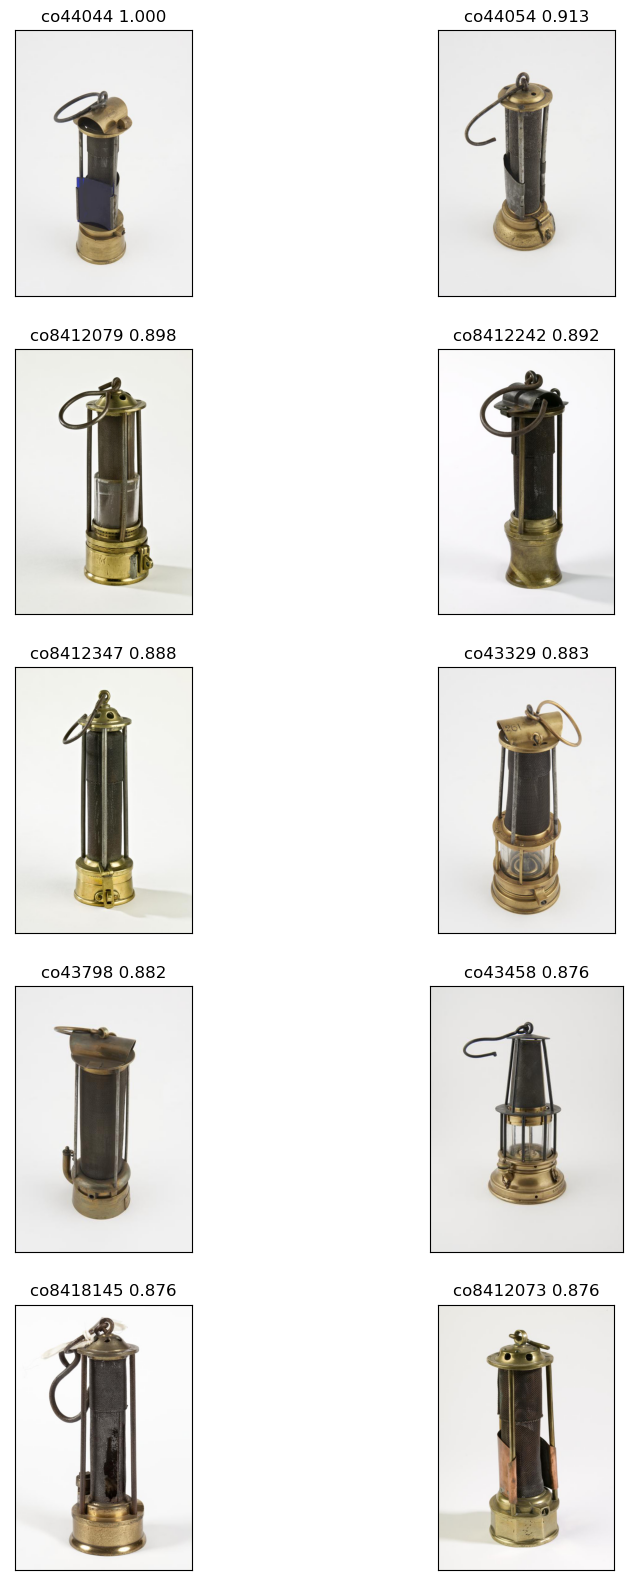

In [155]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}

results = collection_db.query(query_uris=[query_img],where=filters, n_results=25)
query_df = plot_query_results(results, collection_df)

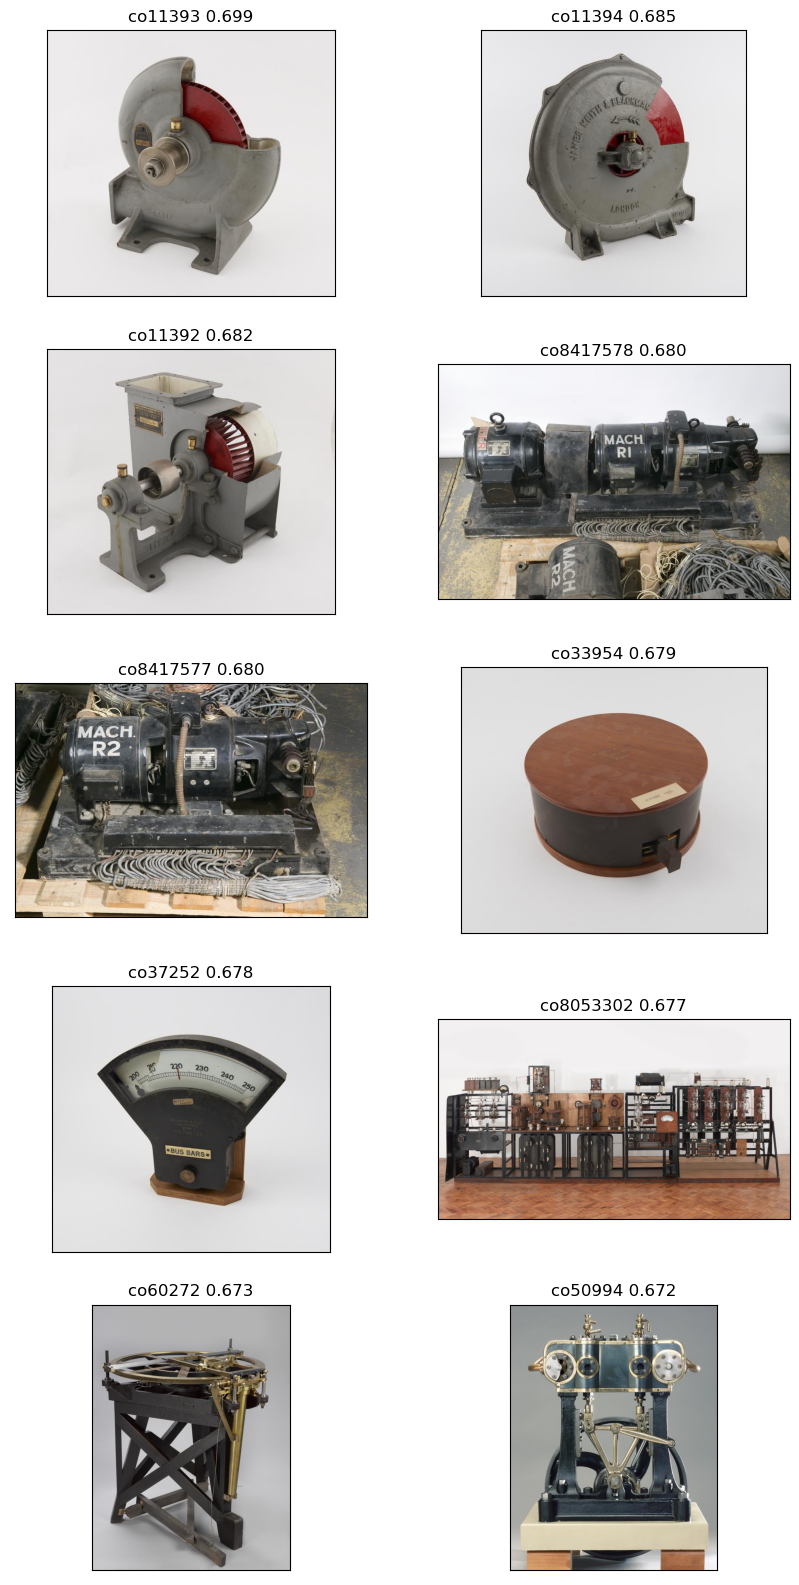

In [157]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "text"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}


results = collection_db.query(
                query_texts=[
                        """BTH valve, type A.T.26, serial No. 575, (RMW/J89 - McVitie Weston number), by British Thomson-Houston Company Limited."""
                    ],
                where=filters,n_results=100
        )
query_df = plot_query_results(results)

In [110]:
query_df.description.values[:10]

array(["Tuner Aircraft Valve Mk. 1 marked 'Tuner Aircraft No 9,' also known as one of the earliest valve tuner for aircraft, first made in 1916. Very few were made - possibly as few as around 100 - with all sets made at the War Department Wireless Telegraphy factory at Teddington, Middlesex. This particular set is a very early example as indicated by 'no. 9' and is also inscribed 'W/T factory W.D. Teddington S.W.'",
       "Fixings, for large main jigger (oscillation transformer) in wood case (No. 72260), made by Marconi's Wireless Telegraph Company Limited, Chelmsford, Essex, England, 1900-1950",
       'Thermionic valve, triode, manufactured by A. C. Cossor Ltd, 1924, A26; Type no. PL; red capped',
       'Hysteresis motor type D-997-A, no. 485238, developed for facsimile machines by Muirhead and Co. Ltd.',
       "D'Arsonval Galvanometer no. 151668, by Muirhead and Co. Ltd., December, 1947",
       'Microfarad condenser no. 1013 by Latimer Clark, Muirhead and Co. Ltd., made for the 

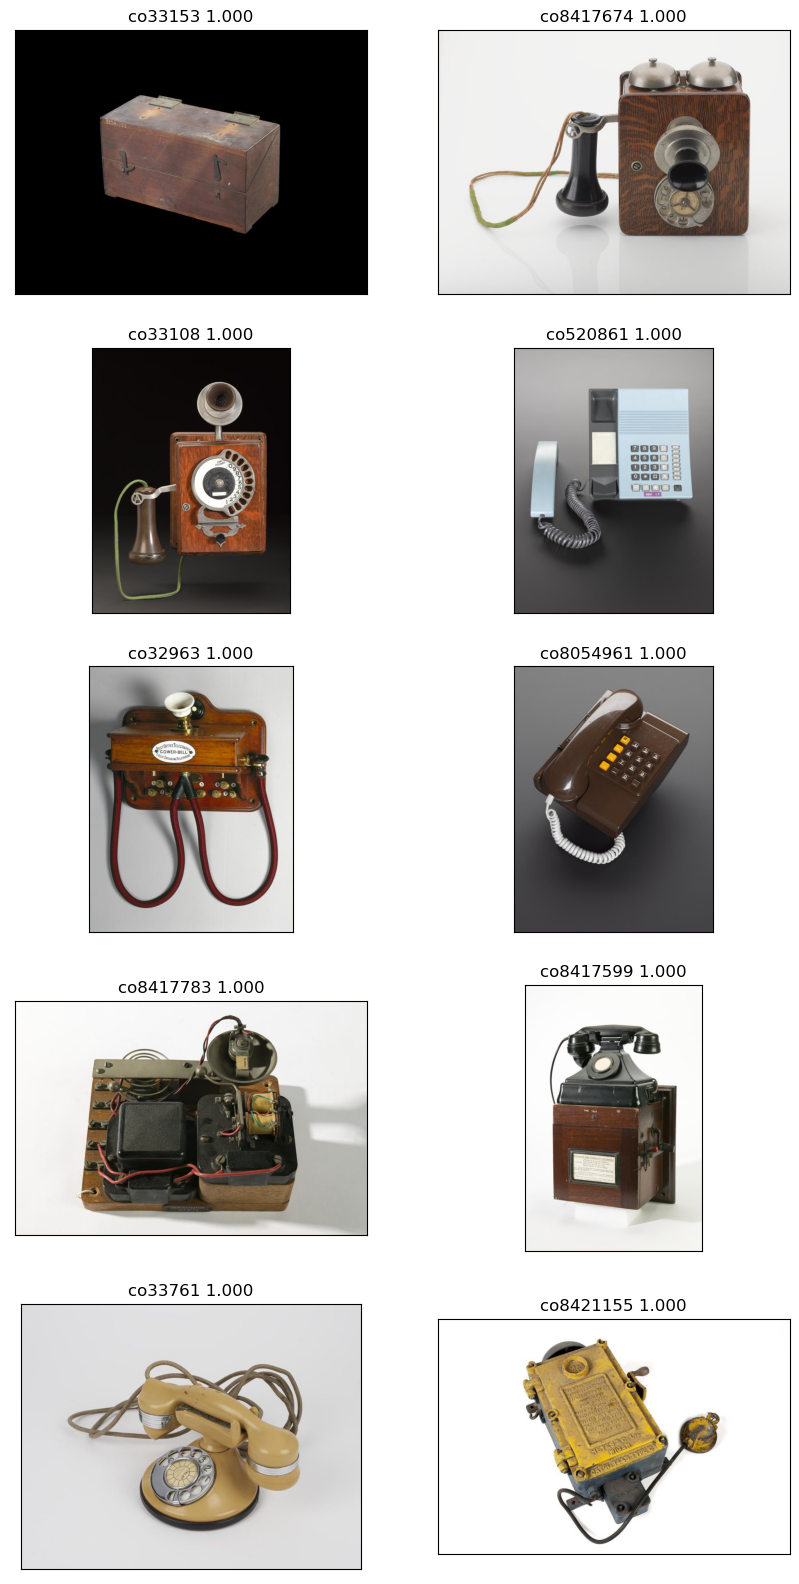

In [160]:

results = collection_db.query(query_texts=["telephone"],
                             where={"modality": "text"},n_results=100)

query_df = plot_query_results(results, collection_df)

In [116]:
query_df.description.values[:10]

array(['Telephone handset, two-tone light brown and black, push button, Model 76E Digital 2000, made by Standard Electric Kirk, Denmark, 1982',
       'Telephone handset, black, dial, model K500, made by ITT Telecommunications, USA, 1973',
       "Technophone EXCELL PC105T mobile telephone, manufactured by Technophone Limited, Camberley, Surrey, England, 1986.; Technophone EXCELL PC105T mobile telephone, manufactured by Technophone Limited, Camberley, Surrey, England, 1986. Released in 1986 and marketed as the first phone to fit in a shirt pocket, the EXCELL PC105T was the brainchild of Nils Martensson a former employee of mobile technology giant Sony Ericsson. The phone was developed with a grant from the UK's Department for Trade and Industry, and its small size inspired government policy makers to see the mass-market potential of mobiles, even though at £1990 when first sold it was far too expensive for most people to be able to own a phone like this.",
       'Aluminium finial for 

## Fin.